In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"samuxiii","key":"*****************"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset
!unzip -qo the-simpsons-characters-dataset.zip -d data

the-simpsons-characters-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
# Remove duplicated folders
!rm -rf data/simpsons_dataset/simpsons_dataset
!mv data/kaggle_simpson_testset/kaggle_simpson_testset/* data/kaggle_simpson_testset/
!rm -rf data/kaggle_simpson_testset/kaggle_simpson_testset

In [3]:
import os
import glob
import random
import numpy as np
import tensorflow.compat.v1 as tf
import tensorflow.python.util.deprecation as deprecation
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

from os import listdir
from PIL import Image
from imageio import imread
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.disable_v2_behavior() 

## Data Loader And Accessor

### _Finding a Valid Image Size_

The images don't have the same dimension size so the first thing we'll have to do is rescaling them since the model will only accept a specific image size. The __strategy__ to find out this value will be averaging the size in the test dataset.

After that, the whole training set will be rescaled using this value.

### _Utils for Creating Batches_

During the training stage it's not a good idea to load the whole set of images in the memory since we might run out of memory. Thus, we'll need a kind of generator method that give us batches of images to keep it in memory until we don't need it anymore.

In [4]:
class Data:
    def __init__(self, train_root_path, test_root_path):
        self.TRAIN_ROOT_PATH = train_root_path
        self.TRAIN_CHARACTER_NAMES = listdir(train_root_path)
        self.TRAIN_NUM_CHARACTERS = len(self.TRAIN_CHARACTER_NAMES)

        self.TEST_ROOT_PATH = test_root_path
        self.TEST_IMAGE_NAMES = listdir(test_root_path)
        self.TEST_NUM_IMAGES = len(self.TEST_IMAGE_NAMES)
        self.AVG_SIZE = self.__calculate_size_average__()

    def __calculate_size_average__(self):
        width = 0
        height = 0

        for i in range(self.TEST_NUM_IMAGES):
            path_file = os.path.join(self.TEST_ROOT_PATH, self.TEST_IMAGE_NAMES[i])
            image = imread(path_file)
            width += image.shape[0]
            height += image.shape[1]

        width_mean = width // self.TEST_NUM_IMAGES
        height_mean = height // self.TEST_NUM_IMAGES
        dim_size = round( (width_mean + height_mean) // 2 )

        print("Average Size is set to: {}\n".format(dim_size))
        return dim_size


    def get_test_sample(self):
        idx = random.randint(0, self.TEST_NUM_IMAGES)
        sample_file, sample_name = self.TEST_IMAGE_NAMES[idx], self.TEST_IMAGE_NAMES[idx].split('_')[:-1]
        return idx, os.path.join(self.TEST_ROOT_PATH, sample_file), '_'.join(sample_name)


    def imresize(self, im):
        return np.array(Image.fromarray(im).resize((self.AVG_SIZE, self.AVG_SIZE)))


    def get_num_of_train_samples(self):
        total_images_counter = 0
        for _, character in enumerate(self.TRAIN_CHARACTER_NAMES):
            path = os.path.join(self.TRAIN_ROOT_PATH, character)
            total_images_counter += len(listdir(path))
            
        return total_images_counter


    def get_train_batch(self, batch_init, batch_size):
        data = {'image':[], 'label':[]}
        character_batch_size = batch_size // self.TRAIN_NUM_CHARACTERS
        character_batch_init = batch_init // self.TRAIN_NUM_CHARACTERS
        character_batch_end = character_batch_init + character_batch_size
        
        for _, character in enumerate(self.TRAIN_CHARACTER_NAMES):
            path = os.path.join(self.TRAIN_ROOT_PATH, character)
            images_list = listdir(path)

            if len(images_list) == 0:
                continue

            for i in range(character_batch_init, character_batch_end):
                '''
                In case the selected character has less images than the batch,
                we recalculate the index preventing the overflow
                '''
                if i >= len(images_list):
                    p = i % len(images_list)
                else:
                    p = i
                    
                path_file = os.path.join(path, images_list[p])
                image = imread(path_file)

                # Rescale the image and keep it in the dictionary
                image = self.imresize(image)
                data['image'].append(image)
                data['label'].append(character)
        
        return data


    def get_train_batches(self, num_batches, batch_size, verbose=False):
        # Maximum number of samples
        num_samples = self.get_num_of_train_samples()
        # Obtain the maximum number of batches
        max_num_batches = num_samples // batch_size - 1
        
        if verbose:
            print("Number of samples:{}".format(num_samples))
            print("Batches:{} Size:{}".format(num_batches, batch_size))
        assert num_batches <= max_num_batches, "Surpassed the maximum number of batches"
            
        for i in range(0, num_batches):
            init = i * batch_size
            if verbose:
                print("Batch-{} yielding images from {} to {}...".format(i, init, init+batch_size))
            
            yield self.get_train_batch(init, batch_size)



In [5]:
data = Data("./data/simpsons_dataset", "./data/kaggle_simpson_testset")
print("* Showing data info:")
print("  - Character names for training: {}".format(data.TRAIN_CHARACTER_NAMES[:5]))
print("  - Sample of test images: {}".format(data.TEST_IMAGE_NAMES[:3]))


Average Size is set to: 147

* Showing data info:
  - Character names for training: ['sideshow_mel', 'homer_simpson', 'selma_bouvier', 'chief_wiggum', 'abraham_grampa_simpson']
  - Sample of test images: ['nelson_muntz_9.jpg', 'krusty_the_clown_33.jpg', 'edna_krabappel_43.jpg']


### Showing a Test Sample

 Id: 728
 Image Label: principal_skinner
 Image Shape: (149, 103, 3)


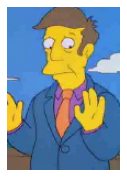

In [6]:
idx, sample_path, sample_name = data.get_test_sample()
sample_image = imread(sample_path)

print(" Id: {}\n Image Label: {}\n Image Shape: {}".format(idx, sample_name, sample_image.shape))
plt.figure(figsize=(3,3))
plt.imshow(sample_image)
plt.axis('off')
plt.show()

Testing the batches methods:

In [7]:
# Testing generator
batch_size = 500
num_batches = 3

for b in data.get_train_batches(num_batches, batch_size, verbose=True):
    print("\t|- retrieved {} images".format(len(b['image'])))

Number of samples:20933
Batches:3 Size:500
Batch-0 yielding images from 0 to 500...
	|- retrieved 462 images
Batch-1 yielding images from 500 to 1000...
	|- retrieved 462 images
Batch-2 yielding images from 1000 to 1500...
	|- retrieved 462 images


### Helpers

In [8]:
# Normalization function
'''
Feature scaling to have all the images in the same space; in this case between (0,1)
'''
def normalize(x):
    return (x - np.amin(x))/(np.amax(x) - np.amin(x))

'''
The model will be a classifier, so the labels will be 'hot encoded'
'''
class OneHotEncoder:
    def __init__(self, classes_list):
        self.lb = preprocessing.LabelBinarizer().fit(classes_list)

    def one_hot(self, label):
        return self.lb.transform([label])

    def label(self, onehot):
        return self.lb.inverse_transform(onehot)

### Preprocess The Images And Store The Batches On Disk

In [9]:
NUM_BATCHES = 40
BATCH_SIZE = 500

In [10]:
encoder = OneHotEncoder(data.TRAIN_CHARACTER_NAMES)
cnt_images = 0

for cnt, b in enumerate(data.get_train_batches(NUM_BATCHES, BATCH_SIZE)):
    processed_data = {'image':[], 'label':[]}
    
    for i in range( min(len(b['image']), batch_size) ):
        image = np.array( b['image'][i] )
        label = np.array( b['label'][i] )

        if len(image.shape) == 3:
          processed_data['image'].append(normalize(image))
          processed_data['label'].append(encoder.one_hot(label)[-1,:])
          cnt_images += 1
        else:
          print("Dim image < 3. Not supported shape, skip.")
    
    with open("simpson_train_{}.pkl".format(cnt), 'wb') as file:
        pickle.dump(processed_data, file, pickle.HIGHEST_PROTOCOL)
    
print("{} train images have been preprocesed and stored on disk".format(cnt_images))

18480 train images have been preprocesed and stored on disk


In [11]:
# Testing how to load from file
with open('simpson_train_0.pkl', 'rb') as file:
    processed_data = pickle.load(file)
    print("Example of onehot encoded:\n{}".format(processed_data['label'][0]))
    print("Data shape: {}".format(processed_data['image'][0].shape))

Example of onehot encoded:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0]
Data shape: (147, 147, 3)


###* _Note:_

_At this point the training images are already clean, rescaled and stored in pickles files._

### Building the Model

In [12]:
# Helper Functions

def convolution_layer(inputs, kernel_shape, stride_shape, output_depth):
    # Convolution variables
    input_depth = inputs.get_shape().as_list()[3]
    filter_shape = kernel_shape + (input_depth, output_depth)
    dev = 1/np.sqrt(kernel_shape[0]*kernel_shape[1])
    filter_ = tf.Variable(tf.truncated_normal(filter_shape, stddev=dev), name="filter_")
    stride_shape = (1,) + stride_shape + (1,)
    pool_shape = stride_shape
    bias_ = tf.Variable(tf.truncated_normal([output_depth], stddev=dev), name="bias_")
    
    # Convolution
    x = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    x = tf.nn.bias_add(x, bias_)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, pool_shape, stride_shape, padding='SAME')
    
    return x

def dense_layer(inputs, num_outputs):
    # Dense variables
    num_inputs = inputs.get_shape().as_list()[1]
    dev = 1/np.sqrt(num_inputs)
    weights = tf.Variable(tf.truncated_normal((num_inputs,)+num_outputs, stddev=dev), name="weights")
    bias = tf.Variable(tf.truncated_normal(num_outputs, stddev=dev), name="bias")
    
    return tf.add(tf.matmul(inputs, weights), bias)

In [13]:
class SimpsonsClassifier:

    def __init__(self, dim_size, num_classes):
        # Shape
        self.image_shape = (dim_size, dim_size, 3)
        self.label_shape = (num_classes,)

        # Data
        self.X = tf.placeholder(tf.float32, (None,) + self.image_shape)
        self.y = tf.placeholder(tf.float32, (None,) + self.label_shape)

        # Model
        self.logits = None
        self.cost = None
        self.optimizer = None
        self.accuracy = None
        self.__build__()

    def __build__(self):
        # Convolutions
        print("Inputs shape: {}".format(self.X.get_shape().as_list()[1:]))

        conv = convolution_layer(self.X, (5,5), (2,2), 32)
        print("Convlution_1 layer shape: {}".format(conv.get_shape().as_list()[1:]))
        
        conv = convolution_layer(conv, (5,5), (2,2), 64)
        print("Convolution_2 layer shape: {}".format(conv.get_shape().as_list()[1:]))
            
        # Before classifier
        flatten_shape = np.prod(conv.get_shape().as_list()[1:])
        flatten = tf.reshape(conv, [-1, flatten_shape])

        # Classifying
        self.logits = dense_layer(flatten, self.label_shape)

        print("Dense layer shape: {}".format(flatten_shape))
        print("Outputs shape: {}".format(self.logits.get_shape().as_list()[1]))

        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.y))
        self.optimizer = tf.train.AdamOptimizer().minimize(self.cost)

        correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



In [14]:
# Building the network
tf.reset_default_graph()

model = SimpsonsClassifier(data.AVG_SIZE, data.TRAIN_NUM_CHARACTERS)

Inputs shape: [147, 147, 3]
Convlution_1 layer shape: [37, 37, 32]
Convolution_2 layer shape: [10, 10, 64]
Dense layer shape: 6400
Outputs shape: 42


In [15]:
# Variables
x_train = []
y_train = []
x_val = []
y_val = []

EPOCHS = 10
NUM_PICKLE_BATCHES = len(glob.glob1(".", "simpson_train_*.pkl"))

# Train the model
sess = tf.Session()
sess.run(tf.global_variables_initializer())
stats = {'train_loss':[], 'val_loss':[], 'acc':[]}

print("Number of pickle files to be processed: {}".format(NUM_PICKLE_BATCHES))

for e in range(EPOCHS):
    for i in range(NUM_PICKLE_BATCHES):

        fname = "simpson_train_{}.pkl".format(i)

        if os.path.exists(fname):   
            with open(fname, 'rb') as file:
                proc_images = pickle.load(file)
                x_train, x_val, y_train, y_val = train_test_split(proc_images['image'], proc_images['label'], test_size=0.2, random_state=42)

                feed_dict = {model.X: x_train, model.y: y_train}
                train_loss, _ = sess.run([model.cost, model.optimizer], feed_dict)

                feed_dict = {model.X: x_val, model.y: y_val}
                val_loss, acc = sess.run([model.cost, model.accuracy], feed_dict)

                # Storing stats
                stats['train_loss'].append(train_loss)
                stats['val_loss'].append(val_loss)
                stats['acc'].append(acc)
                
                # Enough accuracy
                if acc > 0.8:
                  break
                
    print("Epoch:{} Training Loss:{:.4f} Validation Loss:{:.4f} Accuracy:{:.4f}".format(e, train_loss, val_loss, acc))
    
    # Stop iterating over epochs when accuracy is greater than 80%
    if acc > 0.8:
      break


Number of pickle files to be processed: 40
Epoch:0 Training Loss:1.6895 Validation Loss:1.6166 Accuracy:0.6129
Epoch:1 Training Loss:0.9006 Validation Loss:0.8202 Accuracy:0.7204
Epoch:2 Training Loss:0.6670 Validation Loss:0.8983 Accuracy:0.8172


In [16]:
with open("stats.pkl", 'wb') as file:
    pickle.dump(stats, file, pickle.HIGHEST_PROTOCOL)

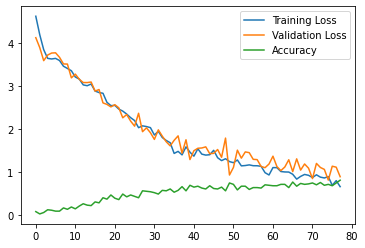

In [17]:
# Don't plot the first 5 stats, they're in a big scale
plt.plot(stats['train_loss'][5:], label='Training Loss')
plt.plot(stats['val_loss'][5:], label='Validation Loss')
plt.plot(stats['acc'][5:], label='Accuracy')
plt.legend()

### Testing the Model

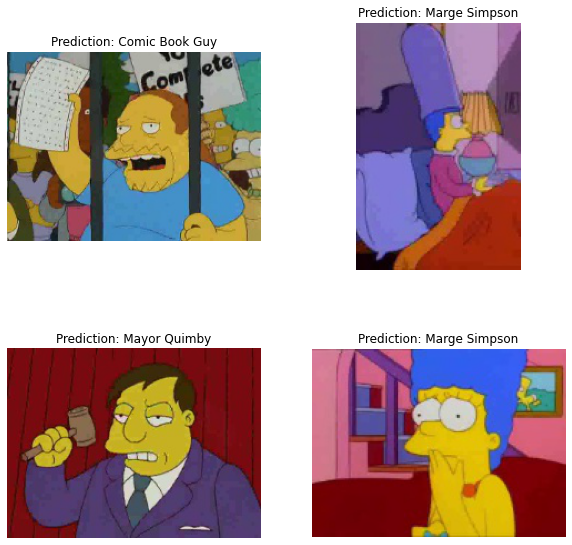

In [19]:
if data == None:
    data = Data("./data/simpsons_dataset", "./data/kaggle_simpson_testset")
    encoder = OneHotEncoder(data.TRAIN_CHARACTER_NAMES)

def test():
    idx, sample_path, sample_name = data.get_test_sample()
    sample_image = imread(sample_path)
        
    test_image = sample_image
    test_label = ' '.join([s.capitalize() for s in sample_name])

    test_image_norm = normalize(data.imresize(sample_image))
    prediction = sess.run(model.logits, {model.X:[test_image_norm]})
    prediction = encoder.label(prediction)

    # Showing
    prediction = ' '.join([s.capitalize() for s in prediction[0].split('_')])

    return test_image, test_label, prediction

# Execute and show
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axs.ravel()):
    test_image, test_label, prediction = test()
    ax.set_title("Prediction: {}".format(prediction))
    ax.imshow(test_image)
    ax.axis('off')
plt.show()
